Гафни Даниил, 306 группа, физический факультет МГУ

Решение двумерного уравнения теплопроводности

# В РАЗРАБОТКЕ

### Импортируем необходимые библиотеки

In [1]:
import numpy as np

import plotly
import plotly.graph_objs as go

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings

from IPython.display import clear_output, HTML, display, Image

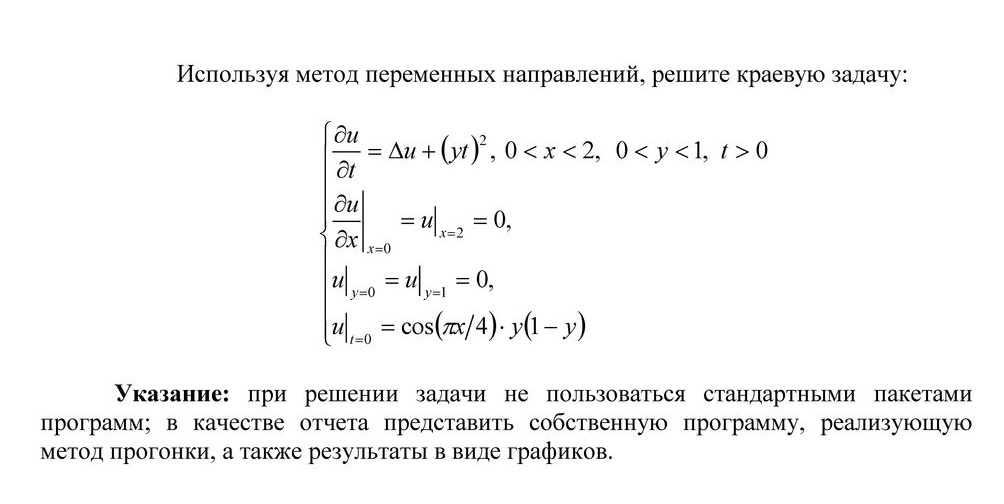

In [2]:
Image("task.jpg")

### Проведем необходимые настройки

In [2]:
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Наведем красоту
layout = go.Layout(
    scene = dict(
    xaxis = dict(
        title='x',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(200, 200, 230)"),
                        
    yaxis = dict(
        title='y',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 200,230)"),
                        
    zaxis = dict(
        title='u(x, t)',
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)",
        showbackground=True,
        backgroundcolor="rgb(230, 230,200)",),),
    width=800, height=600, 
    margin=dict(
        r=20, b=10,
        l=10, t=10),
    )

In [3]:
def TDMA(data, F):
    '''
    Метод прогонки.
        
    Параметры: 
        coeffs (numpy.array): Трехдианональная матрица коэффициентов уравнений.
        F (numpy.array): Массив правых частей уравнений.
    Вывод:
        (numpy.array): Массив искомых значений неизвестной.
    '''
        
    N = len(F)
    x = [0]*(N)
    A = []
    C = [data[0][0]]
    B = [data[0][1]]
    for i in range(1, N-1):
        A.append(data[i][i-1])
        C.append(data[i][i])
        B.append(data[i][i+1])
    A.append(data[-1][-2])
    C.append(data[-1][-1])

    alpha = [-B[0]/C[0]]*(N-1)
    beta = [F[0]/C[0]]*(N-1)

    for i in range(1, N-1):
        alpha[i] = -B[i]/(A[i-1]*alpha[i-1] + C[i])
        beta[i] = ((F[i] - A[i-1]*beta[i-1])/(A[i-1]*alpha[i-1] + C[i]))  
    x[-1] = (F[-1] - A[-1]*beta[-1]) / (C[-1] + A[-1]*alpha[-1])
    for i in reversed(range(N-1)):
        x[i] = alpha[i]*x[i+1] + beta[i]
    return(np.array(x))

In [4]:
class HeatEquationSolver_2():
    '''
    Класс для численного решения двумерного уравнения теплопроводности.
    '''
    def __init__(self,
                 X_START=0, X_END=2,
                 Y_START=0, Y_END=1,
                 T_START=0, T_END=10,
                 N=5, M=5, J=5):
        
        self.X_START = X_START
        self.X_END = X_END
        self.Y_START = Y_START
        self.Y_END = Y_END
        self.T_START = T_START
        self.T_END = T_END
        self.N = N
        self.M = M
        self.J = J
        
        self.x = np.linspace(X_START, X_END, N)
        self.y = np.linspace(Y_START, Y_END, M)
        self.t = np.linspace(T_START, T_END, J)
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = self.t[1] - self.t[0]
    
    def initialize(self, a=0, f=lambda x, y, t:0, fi=lambda x, y:0,
                   gamma1x=0, gamma2x=0, delta2x=0, delta1x=0, mu1x=lambda x:0, mu2x=lambda x:0,
                   gamma1y=0, gamma2y=0, delta2y=0, delta1y=0, mu1y=lambda x:0, mu2y=lambda x:0):
        '''
        Задание коэффициентов и функций конкретной задачи.
        '''
        
        self.a = a
        self.f = f
        self.fi = fi
        
        self.gamma1x = gamma1x
        self.gamma2x = gamma2x
        self.delta1x = delta1x
        self.delta2x = delta2x
        self.mu1x = mu1x
        self.mu2x = mu2x
        
        self.gamma1y = gamma1y
        self.gamma2y = gamma2y
        self.delta1y = delta1y
        self.delta2y = delta2y
        self.mu1y = mu1y
        self.mu2y = mu2y
        
        self.u = np.zeros((self.J, self.N, self.M))
        
        self.u[0] = [[self.fi(x, y) for y in self.y] for x in self.x]
        
    def calculate_layer(self, j):
        
        step_x = self.dx
        step_y = self.dt
        step_t = self.dt/2
          
        # Переход к промежуточному слою
        middle_layer = [np.array([0]*self.N)]*(self.M)
        for m in range(1, self.M-1):            
            data = np.zeros((self.N, self.N))
            data[0][0] = step_x*self.delta1x + self.gamma1x
            data[0][1] = -self.gamma1x        
            data[-1][-2] = -self.gamma2x
            data[-1][-1] = step_x*self.delta2x + self.gamma2x
        
        
            for i in range(1, self.N - 1):
                data[i][i-1] = self.a**2*step_t/step_x**2
                data[i][i] = -(2*self.a**2*step_t/step_x**2 + 1)
                data[i][i+1] = self.a**2*step_t/step_x**2
        
            F = [0]*self.N
            F[0], F[-1] = step_x*self.mu1x(self.t[j]+step_t), step_x*self.mu2x(self.t[j]+step_t)
            for k in range(1, self.N-1):
                F[k] = (-self.f(self.x[k], self.y[m], self.t[j]+step_t)*step_t - self.u[j-1][k][m] - 
                        self.a**2*step_t/step_y**2 * (self.u[j-1][k][m-1] - 2*self.u[j-1][k][m] + self.u[j-1][k][m+1]))
        
            middle_layer[m] = TDMA(data, F)
        middle_layer = np.array(middle_layer)

        # Переход к новому слою
        new_layer = [np.array([0]*self.M)]*(self.N)
        for n in range(1, self.N-1):            
            data = np.zeros((self.M, self.M))
            data[0][0] = step_y*self.delta1y + self.gamma1y
            data[0][1] = -self.gamma1y
            data[-1][-2] = -self.gamma2y
            data[-1][-1] = step_y*self.delta2y + self.gamma2y
        
        
            for i in range(1, self.M - 1):
                data[i][i-1] = self.a**2*step_t/step_y**2
                data[i][i] = -(2*self.a**2*step_t/step_y**2 + 1)
                data[i][i+1] = self.a**2*step_t/step_y**2
        
            F = [0]*self.M
            F[0], F[-1] = step_y*self.mu1y(self.t[j]+2*step_t), step_y*self.mu2y(self.t[j]+2*step_t)
            for k in range(1, self.M-1):
                F[k] = (-self.f(self.x[n], self.y[k], self.t[j]+2*step_t)*step_t - middle_layer[n][k] - 
                        self.a**2*step_t/step_y**2 * (middle_layer[n-1][k] - 2*middle_layer[n][k] + middle_layer[n+1][k]))
        
            new_layer[n] = TDMA(data, F)
        new_layer = np.array(new_layer)
        return middle_layer
           
    def calculate_u(self):
        print('Calculating...')
        for j in range(1, self.J):
            clear_output(wait = True)
            print(f'Progress: {round(j/(self.J-1), 2)*100}%')
            new_layer = self.calculate_layer(j)
            self.u[j] = new_layer
        
    def plot_state(self, num = 0, filename = 'OMM_Task_2_initial_conditions',
                       online = True):
        '''
        Метод, который строит график начального и граничного условий.
        '''

        data = [go.Surface(x = self.x, y = self.y, z = self.u[num], colorscale = 'YlGnBu')]
        fig = go.Figure(data = data, layout = layout)
        if online:
            return py.iplot(fig, filename = filename)
        if not online:
            return plotly.offline.iplot(fig, filename = filename) 
        
    def plot_initial_state(self, filename = 'OMM_Task_2_initial_conditions',
                       online = True):
        self.plot_state(num = 0, filename = filename,
                       online = online)
    
    def visualise_evolution(self, filename = 'basic_animation_1'):
        '''Метод, который возвращает анимацию временной эволюции u(x, t),
        а так же записывает ее в .mp4 видеофайл.
        '''
        
        fig = plt.figure(dpi = 200)
        ax = plt.axes(xlim=(self.X_START*0.9, self.X_END*1.1),
                      ylim=(np.min(self.u.T)*0.9, np.max(self.u.T)*1.1))
        
        ax.set_title('Evolution of u(x, t)')
        ax.set_ylabel('u(x, t)', fontsize = 12)
        ax.set_xlabel('x', fontsize = 12)

        line, = ax.plot([], [], lw=2)

        textvar = fig.text(0.15, 0.15, '', fontsize = 20)

        def init():
            line.set_data([], [])
            return line,

        def animate(i):
            x = self.x
            y = np.take(self.u[i], -1, axis=0)

            textvar.set_text(f't = {round(self.t[i], 1)}')
            line.set_data(x, y)
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=self.N, interval=5000/self.N, blit=True)
        plt.close(fig)
        anim.save(filename + '.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        
        return anim

In [21]:
solver = HeatEquationSolver_2(X_END = np.pi, Y_END = np.pi, N = 50, M = 50, J = 50)
a = 1
def f(x, y, t):
    return np.cos(x)*np.sin(t)
def fi(x, y):
    return 0
gamma1x = 1
gamma2x = 1
gamma1y = 1
gamma2y = 1
delta1x = 1
delta2x = 1
delta1y = 1
delta2y = 1
solver.initialize(f = f, fi = fi,
                  gamma1x = gamma1x, gamma2x = gamma2x, gamma1y = gamma1y, gamma2y = gamma2y,
                  delta1x = delta1x, delta2x = delta2x, delta1y = delta1y, delta2y = delta2y)

In [22]:
solver.plot_initial_state(online = False)

In [12]:
solver.calculate_u()

Progress: 100.0%


In [16]:
solver.plot_state(400, online = False)

Демонстрация работы метода прогонки:

In [ ]:
data = np.array([
    [2, -1, 0, 0, 0],
    [-3, 8, -1, 0, 0],
    [0, -5, 12, 2, 0],
    [0, 0, -6, 18, -4],
    [0, 0, 0, -5, 10]
])
F = np.array([
    -25, 72, -69, -156, 20
])
TDMA(data, F)

In [91]:
anim = solver.visualise_evolution(filename = 'small_animation')
HTML(anim.to_jshtml())
plt.close()  # <-- Это нужно, чтобы обойти глупый баг, 
             #     который строит ненужный график после первого запуска
HTML(anim.to_jshtml())